In [1]:
import japanize_matplotlib  # noqa
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from pathlib import Path

plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (12, 5)
plt.rcParams["font.size"] = 25
plt.rcParams["xtick.labelsize"] = 25
plt.rcParams["ytick.labelsize"] = 25
plt.rcParams["axes.labelsize"] = 25
plt.rcParams["axes.titlesize"] = 30

RESULT_PATH = Path("../output/result.csv")
METRICS_MAP = {
    "exec_time": "実行時間 (秒)",
    "exec_time_rate": "実行時間の比率",
    "user_util": "利用者満足度",
    "mean_max_envy": "Mean Max Envy",
    "pct_item_util_better": "% Items Better Off",
    "pct_item_util_worse": "% Items Worse Off",
}
METRICS = list(METRICS_MAP.keys())
METHOD_MAP = {
    "greedy": "Greedy",
    "expo_fair": "Exposure-Based",
    "nsw": "NSW",
    "greedy_nsw": "Greedy-NSW",
    "ot_nsw": "OT-NSW（Ours）",
}
METHOD_TO_COLOR = {
    "Greedy": "#E24A33",
    "Exposure-Based": "#348ABD",
    "Exposure-Based (MOSEK) ": "#348ABD",
    "Exposure-Based (SCS) ": "#348ABD",
    "NSW": "#988ED5",
    "NSW (MOSEK) ": "#988ED5",
    "NSW (SCS) ": "#988ED5",
    "Greedy-NSW": "#777777",
    "OT-NSW（Ours）": "#FBC15E",
}
METHOD_TO_LINESTYLE = {
    "Greedy": "-",
    "Exposure-Based": "-",
    "Exposure-Based (MOSEK) ": "--",
    "Exposure-Based (SCS) ": "-",
    "NSW": "-",
    "NSW (MOSEK) ": "--",
    "NSW (SCS) ": "-",
    "Greedy-NSW": "-",
    "OT-NSW（Ours）": "-",
}

In [2]:
def load_result(
    path: Path,
    exp_names: list[str],
    on: list[str] = ["seed"],
    ideal_method: str = "NSW",
    ignore_methods: list[str] = ["pg_ot"],
    consider_solver: bool = False,
    dropna: bool = True,
) -> pd.DataFrame:
    result = pd.read_csv(path)

    # Filter by experiment name
    result = result.query(f"exp_name in {exp_names}")
    # # Filter by optimizer params method
    result = result.query(f"optimizer_params_method not in {ignore_methods}").reset_index(
        drop=True
    )

    # Initialize metrics
    result["exec_time_rate"] = np.nan

    # rename method
    result["method"] = result["optimizer_name"].map(METHOD_MAP)
    if consider_solver:
        result["optimizer_params_solver"] = result["optimizer_params_solver"].apply(
            lambda x: f" ({x}) " if x == x else ""
        )
        result["method"] += result["optimizer_params_solver"]

    #
    ideal = result.query("method == @ideal_method").reset_index(drop=True)
    ideal = ideal.drop_duplicates(subset=on)
    result = pd.merge(
        result[on + ["method"] + METRICS],
        ideal[on + METRICS],
        on=on,
        suffixes=("", "_nsw"),
        how="left",
    )

    # Calculate exec_time_rate
    result["exec_time_rate"] = result["exec_time"] / result["exec_time_nsw"]

    # drop na
    num_na: pd.DataFrame = result[METRICS].isna().sum(axis=0).to_frame()
    num_na.columns = ["number_of_nan"]
    display(num_na)
    if dropna:
        result = result.dropna(subset=METRICS)

    return result.reset_index(drop=True)

# ベースサイズの実験

## データの読み込み

In [3]:
base_size_result = load_result(
    path=RESULT_PATH,
    exp_names=["exp_base"],
    on=["generator_n_query", "generator_n_doc", "generator_K", "seed"],
    consider_solver=False,
)
base_size_result.head(5)

,number_of_nan
exec_time,0
exec_time_rate,0
user_util,0
mean_max_envy,0
pct_item_util_better,0
pct_item_util_worse,0


,generator_n_query,generator_n_doc,generator_K,seed,method,exec_time,exec_time_rate,user_util,mean_max_envy,pct_item_util_better,pct_item_util_worse,exec_time_nsw,exec_time_rate_nsw,user_util_nsw,mean_max_envy_nsw,pct_item_util_better_nsw,pct_item_util_worse_nsw
0,1000,500,10,4,OT-NSW（Ours）,8.352898,0.016294,2.163754,0.000043,96.8,0.4,512.639917,NaN,2.158096,0.000038,97.0,0.0
1,1000,500,10,3,OT-NSW（Ours）,8.293282,0.016120,2.191015,0.000045,96.0,0.0,514.471181,NaN,2.184864,0.000041,97.4,0.0
2,1000,500,10,2,OT-NSW（Ours）,8.475536,0.016358,2.149408,0.000045,96.0,0.2,518.140154,NaN,2.143812,0.000037,97.0,0.2
3,1000,500,10,1,OT-NSW（Ours）,8.548269,0.016041,2.151742,0.000047,97.2,0.2,532.893298,NaN,2.145651,0.000039,97.8,0.0
4,1000,500,10,0,OT-NSW（Ours）,9.120509,0.016737,2.161028,0.000044,96.4,0.2,544.940438,NaN,2.155045,0.000040,97.2,0.0


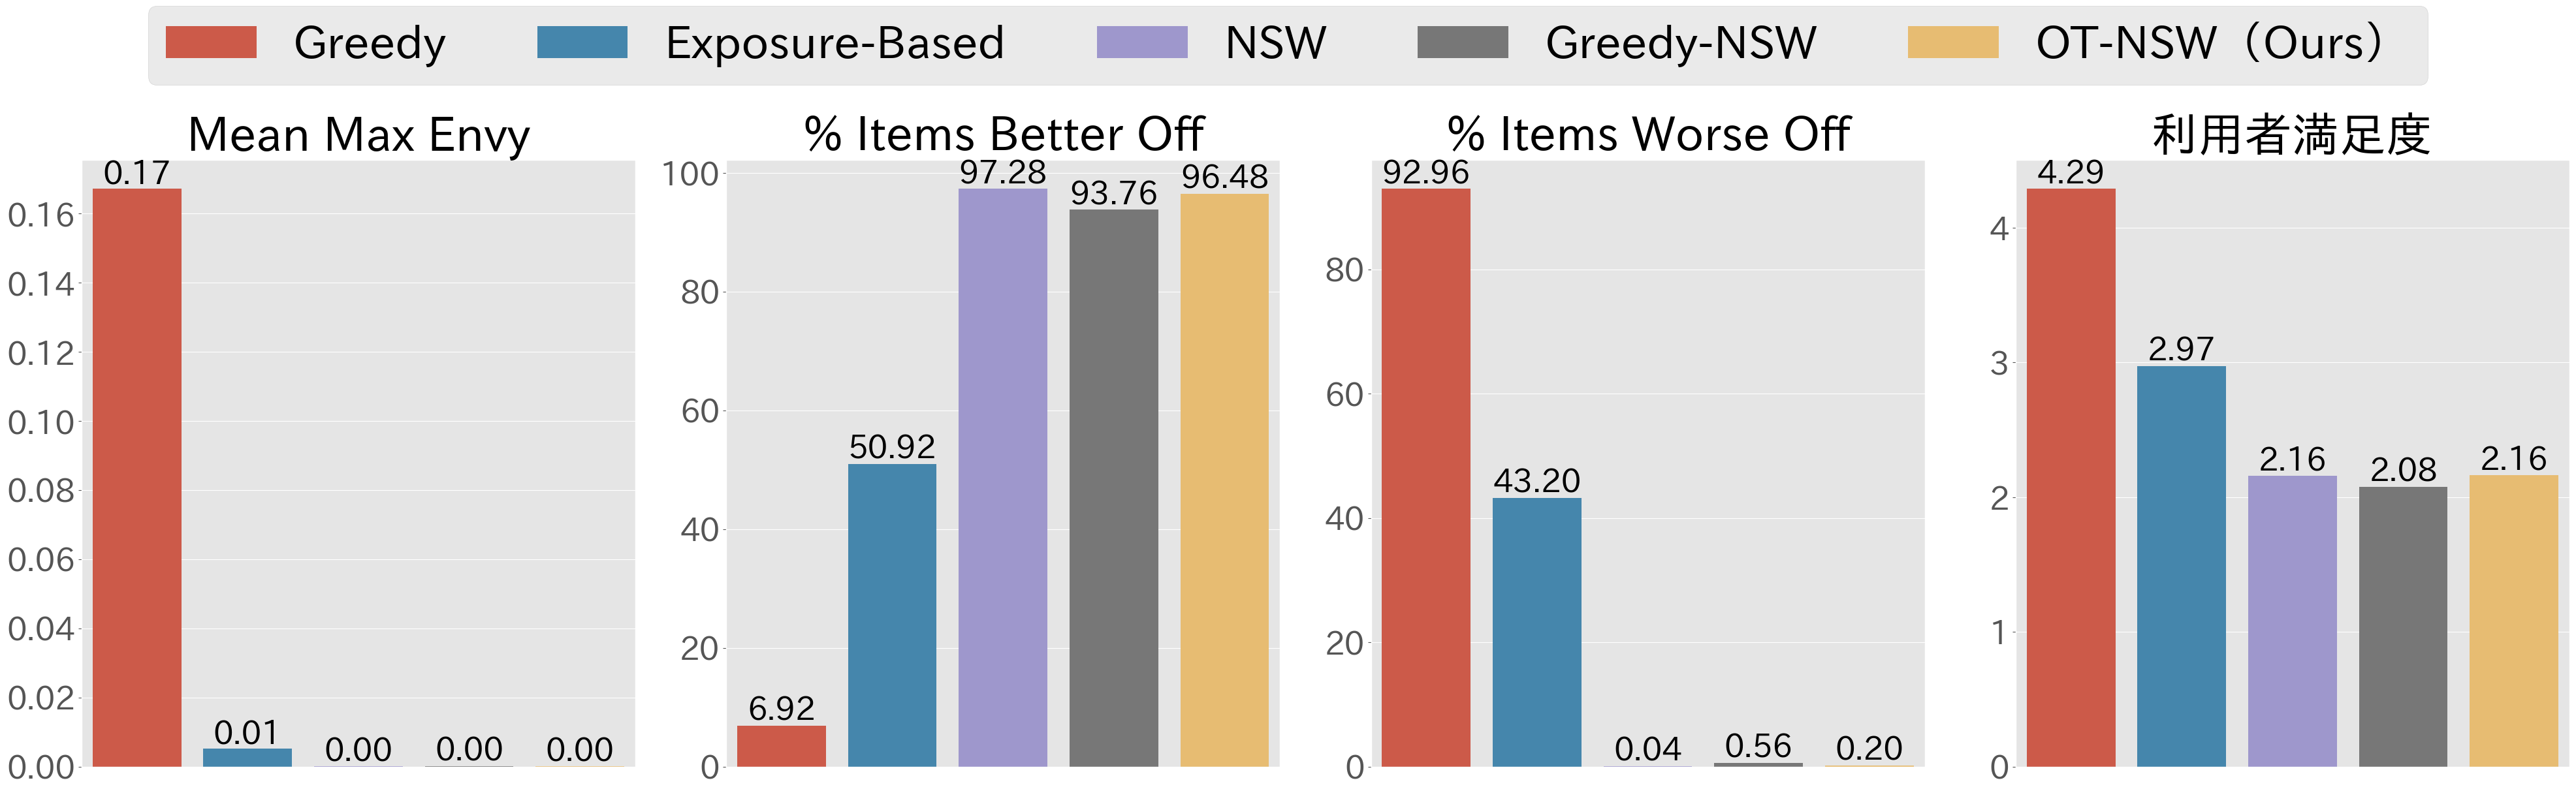

In [4]:
fig, axes = plt.subplots(ncols=4, figsize=(40, 11), tight_layout=True)
axes = np.ravel(axes)

unique_method = base_size_result["method"].unique().tolist()
order = [method for method in METHOD_TO_COLOR.keys() if method in unique_method]
pallete = [METHOD_TO_COLOR[method] for method in order]

for i, metric in enumerate(
    ["mean_max_envy", "pct_item_util_better", "pct_item_util_worse", "user_util"]
):
    ax = sns.barplot(
        base_size_result,
        x="method",
        y=metric,
        ax=axes[i],
        legend=True,
        order=order,
        palette=pallete,
        hue="method",
        hue_order=order,
        errorbar=None,
    )
    ax.set_title(METRICS_MAP[metric], fontsize=52)
    ax.set_ylabel("")
    ax.set_xlabel("")
    ax.tick_params(axis="both", labelsize=35)
    ax.set_xticks([])

    # 棒グラフの上に値を追加
    for j, p in enumerate(ax.patches):
        height = p.get_height()
        if (height == 0) & (p.get_x() == 0):  # monky patch
            continue
        ax.text(
            p.get_x() + p.get_width() / 2,
            height,
            f"{height:.2f}",
            ha="center",
            va="bottom",
            fontsize=35,
        )

    handles, legend = ax.get_legend_handles_labels()
    ax.get_legend().remove()

fig.legend(
    handles,
    legend,
    fontsize=50,
    bbox_to_anchor=(0.5, 1.15),
    ncol=len(order),
    loc="upper center",
)

# アイテム数、利用者数を変化させたときの実験

## 公平性、満足度

In [5]:
def plot_fairness_and_user_utils(result: pd.DataFrame, x: str, xlabel: str):
    fig, axes = plt.subplots(ncols=4, figsize=(45, 10), tight_layout=True)
    axes = np.ravel(axes)

    unique_method = result["method"].unique().tolist()
    order = [method for method in METHOD_TO_COLOR.keys() if method in unique_method]

    for i, metric in enumerate(
        ["mean_max_envy", "pct_item_util_better", "pct_item_util_worse", "user_util"]
    ):
        ax = axes[i]
        for j, method in enumerate(order):
            color = METHOD_TO_COLOR[method]
            sns.lineplot(
                result.query("method == @method"),
                x=x,
                y=metric,
                ax=ax,
                marker="o",
                markersize=15,
                markers=True,
                linewidth=8,
                linestyle=METHOD_TO_LINESTYLE[method],
                legend=True,
                color=color,
                hue="method",
                palette=[color],
            )
        ax.set_title(METRICS_MAP[metric], fontsize=52)
        ax.set_ylabel("")
        ax.set_xlabel(xlabel, fontsize=42)
        ax.tick_params(axis="both", labelsize=35)

        handles, legend = ax.get_legend_handles_labels()
        ax.get_legend().remove()

    fig.legend(
        handles,
        order,
        fontsize=50,
        bbox_to_anchor=(0.5, 1.15),
        ncol=len(order),
        loc="upper center",
    )

In [6]:
varying_item_size_result = load_result(
    path=RESULT_PATH,
    exp_names=["Varying_data_size", "exp_item"],
    on=["generator_n_doc", "seed"],
    consider_solver=False,
)
display(varying_item_size_result.head(5))

varying_user_size_result = load_result(
    path=RESULT_PATH,
    exp_names=["exp_user"],
    on=["generator_n_query", "seed"],
    consider_solver=False,
)
display(varying_user_size_result.head(5))

,number_of_nan
exec_time,1
exec_time_rate,11
user_util,1
mean_max_envy,1
pct_item_util_better,1
pct_item_util_worse,1


,generator_n_doc,seed,method,exec_time,exec_time_rate,user_util,mean_max_envy,pct_item_util_better,pct_item_util_worse,exec_time_nsw,exec_time_rate_nsw,user_util_nsw,mean_max_envy_nsw,pct_item_util_better_nsw,pct_item_util_worse_nsw
0,200,0,Exposure-Based,1541.149970,35.304147,3.001875,0.012050,52.0,41.5,43.653512,NaN,2.180538,0.000096,95.5,0.5
1,100,4,Exposure-Based,438.924162,38.031329,2.938903,0.023787,51.0,45.0,11.541121,NaN,2.154870,0.000238,98.0,0.0
2,100,3,Exposure-Based,427.126773,30.377140,3.039569,0.022610,52.0,41.0,14.060796,NaN,2.225930,0.000199,96.0,1.0
3,100,2,Exposure-Based,672.059160,49.658037,2.890737,0.023891,51.0,44.0,13.533744,NaN,2.131606,0.000220,96.0,0.0
4,100,1,Exposure-Based,456.748672,37.108259,2.969521,0.023372,50.0,42.0,12.308545,NaN,2.172901,0.000224,97.0,0.0


,number_of_nan
exec_time,0
exec_time_rate,0
user_util,0
mean_max_envy,0
pct_item_util_better,0
pct_item_util_worse,0


,generator_n_query,seed,method,exec_time,exec_time_rate,user_util,mean_max_envy,pct_item_util_better,pct_item_util_worse,exec_time_nsw,exec_time_rate_nsw,user_util_nsw,mean_max_envy_nsw,pct_item_util_better_nsw,pct_item_util_worse_nsw
0,1600,4,OT-NSW（Ours）,13.226197,0.014771,2.173196,0.000042,96.4,0.0,895.396821,NaN,2.167042,0.000036,96.8,0.0
1,800,4,OT-NSW（Ours）,6.990836,0.016719,2.164139,0.000048,96.2,0.2,418.126501,NaN,2.158268,0.000039,96.4,0.0
2,400,4,OT-NSW（Ours）,3.703617,0.012886,2.177809,0.000051,96.6,0.4,287.414595,NaN,2.172414,0.000044,98.2,0.2
3,200,4,OT-NSW（Ours）,2.455925,0.015409,2.163572,0.000065,96.0,0.0,159.381404,NaN,2.159656,0.000045,97.0,0.4
4,100,4,OT-NSW（Ours）,2.356256,0.087857,2.180086,0.000075,97.0,0.6,26.819246,NaN,2.168920,0.000050,97.6,0.6


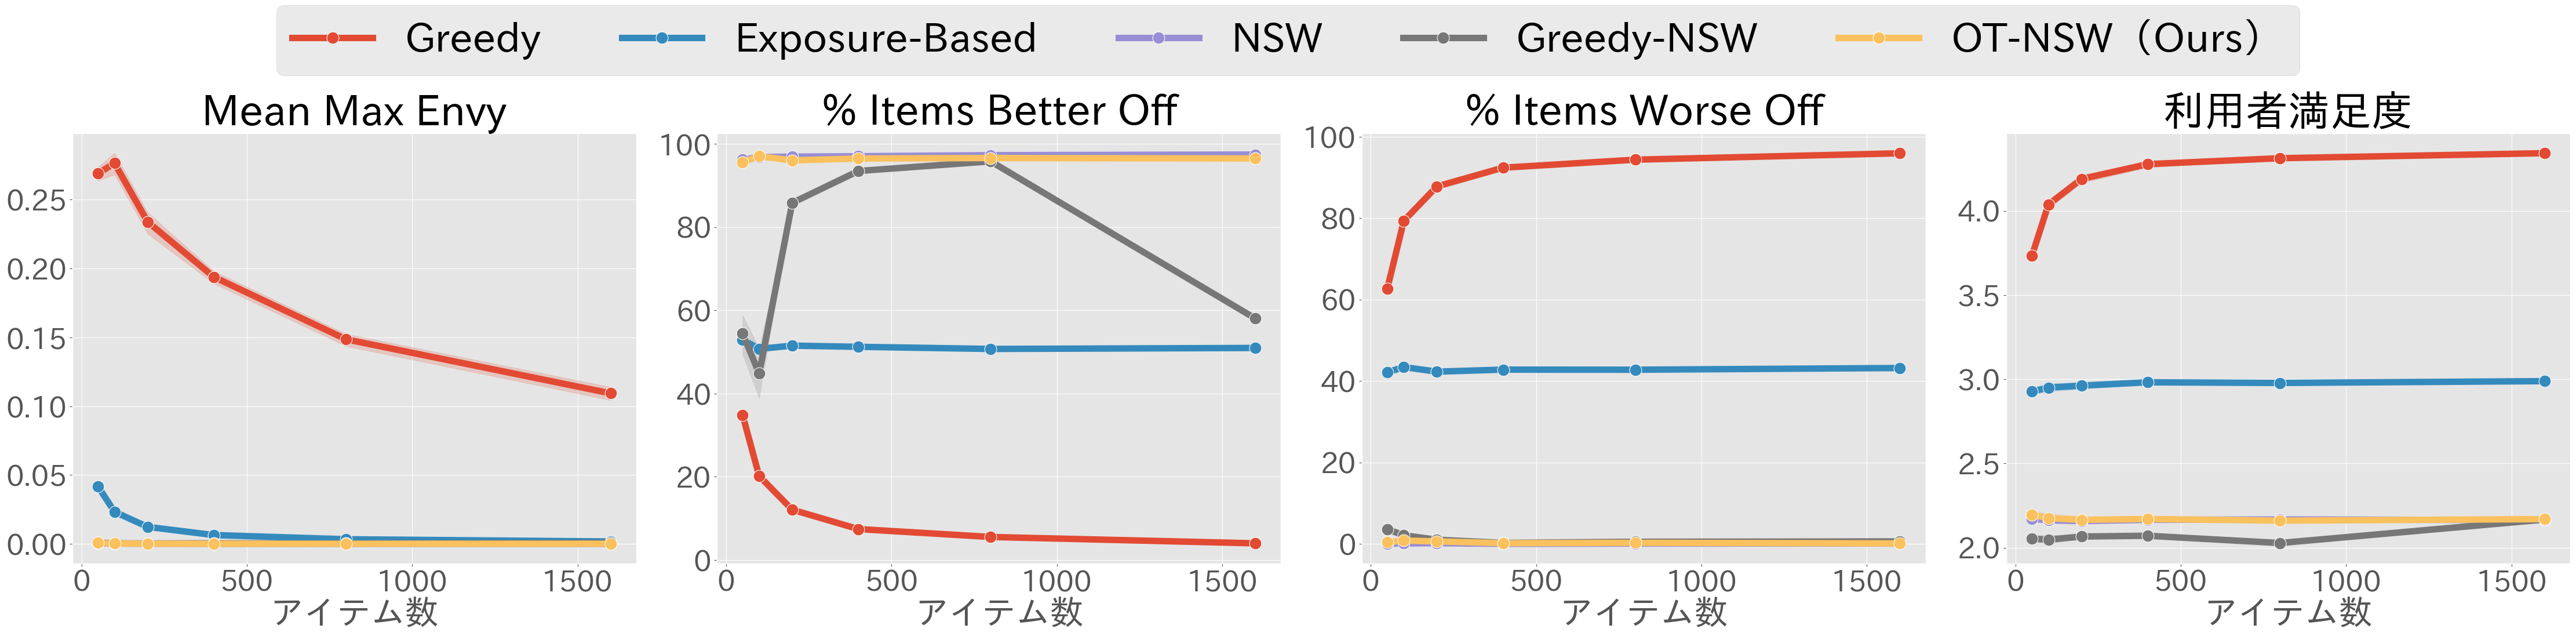

In [7]:
plot_fairness_and_user_utils(varying_item_size_result, x="generator_n_doc", xlabel="アイテム数")

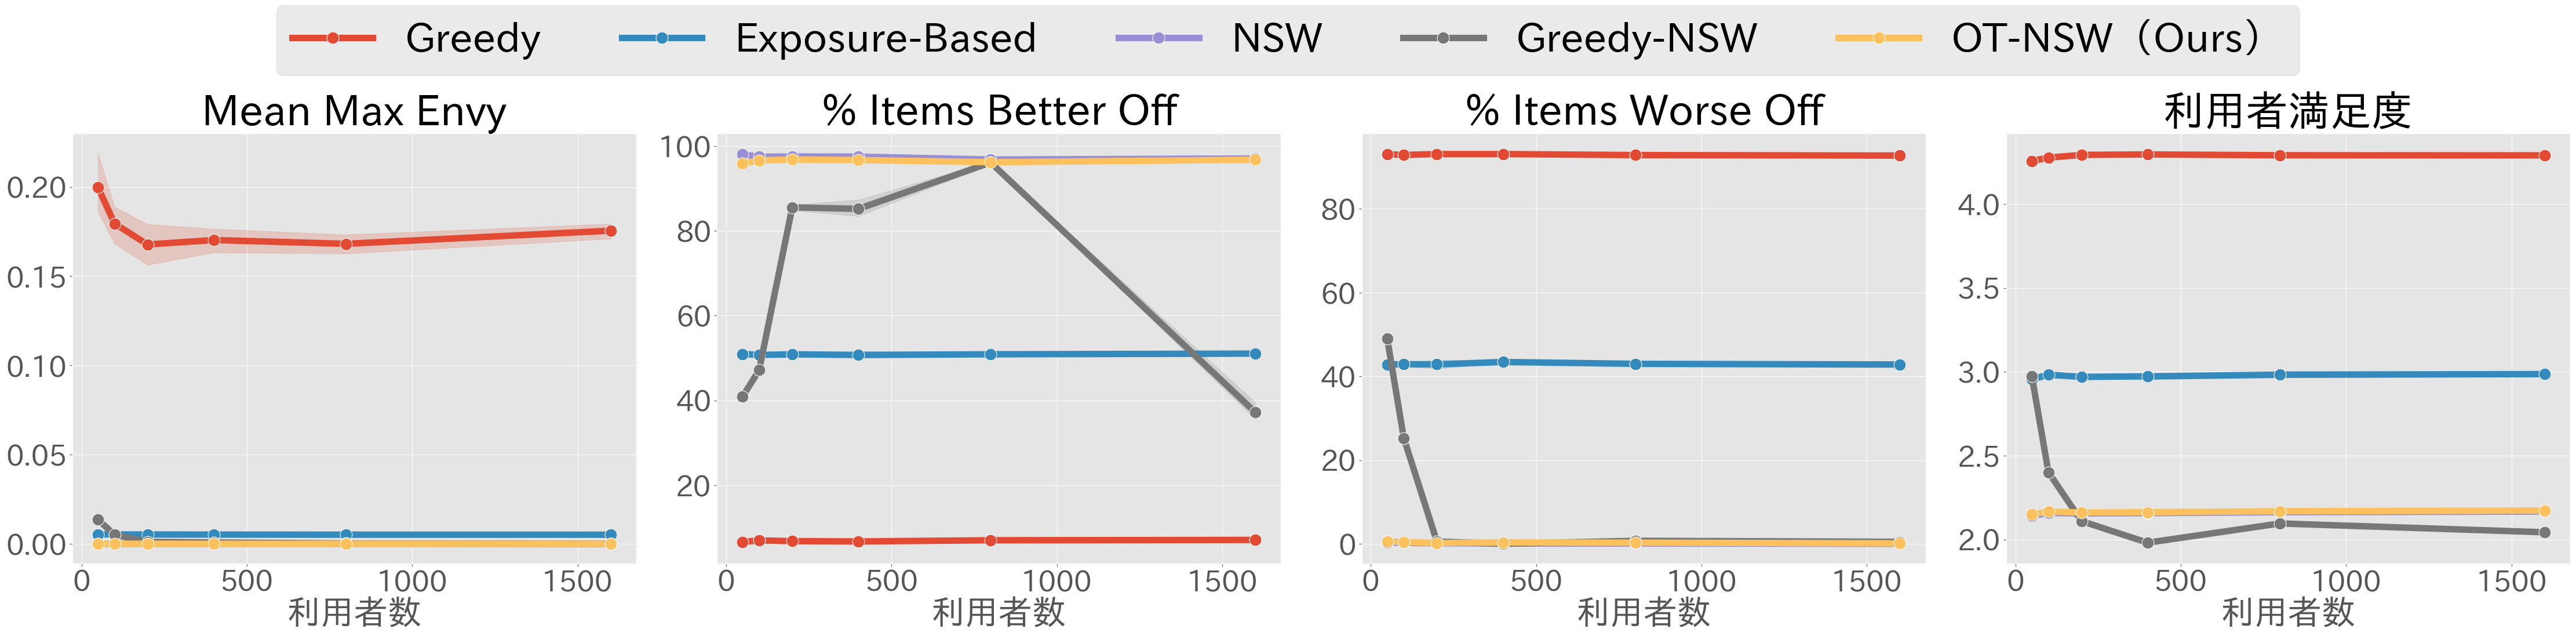

In [8]:
plot_fairness_and_user_utils(varying_user_size_result, x="generator_n_query", xlabel="利用者数")

## 実行時間

In [9]:
def plot_exec_time(
    result: pd.DataFrame,
    x: str,
    xlabel: str,
):
    unique_method = result["method"].unique().tolist()
    order = [method for method in METHOD_TO_COLOR.keys() if method in unique_method]

    for i, metric in enumerate(["exec_time", "exec_time_rate"]):
        ax: plt.Axes
        fig, ax = plt.subplots(figsize=(18, 10))
        for j, method in enumerate(order):
            color = METHOD_TO_COLOR[method]
            sns.lineplot(
                result.query("method == @method"),
                x=x,
                y=metric,
                ax=ax,
                marker="o",
                markersize=15,
                markers=True,
                linewidth=8,
                linestyle=METHOD_TO_LINESTYLE[method],
                legend=True,
                color=color,
                hue="method",
                palette=[color],
            )
        ax.set_ylabel(METRICS_MAP[metric], fontsize=40)
        ax.set_xlabel(xlabel, fontsize=40)
        ax.set_yscale("log")

        handles, legend = ax.get_legend_handles_labels()
        ax.legend(
            handles,
            legend,
            loc="upper center",
            ncol=4,
            bbox_to_anchor=(0.5, 1.20),
        )
        ax.tick_params(axis="both", labelsize=30)

        fig.tight_layout()

In [10]:
# solverを考慮してデータを読み込み
ideal_method = "NSW (MOSEK) "
varying_item_size_result = load_result(
    path=RESULT_PATH,
    exp_names=["Varying_data_size", "exp_item"],
    on=["generator_n_doc", "seed"],
    ideal_method=ideal_method,
    consider_solver=True,
)
display(varying_item_size_result.head(5))

varying_user_size_result = load_result(
    path=RESULT_PATH,
    exp_names=["exp_user"],
    on=["generator_n_query", "seed"],
    ideal_method=ideal_method,
    consider_solver=True,
)
display(varying_user_size_result.head(5))

,number_of_nan
exec_time,1
exec_time_rate,11
user_util,1
mean_max_envy,1
pct_item_util_better,1
pct_item_util_worse,1


,generator_n_doc,seed,method,exec_time,exec_time_rate,user_util,mean_max_envy,pct_item_util_better,pct_item_util_worse,exec_time_nsw,exec_time_rate_nsw,user_util_nsw,mean_max_envy_nsw,pct_item_util_better_nsw,pct_item_util_worse_nsw
0,200,0,Exposure-Based (SCS),1541.149970,35.304147,3.001875,0.012050,52.0,41.5,43.653512,NaN,2.180538,0.000096,95.5,0.5
1,100,4,Exposure-Based (SCS),438.924162,38.031329,2.938903,0.023787,51.0,45.0,11.541121,NaN,2.154870,0.000238,98.0,0.0
2,100,3,Exposure-Based (SCS),427.126773,30.377140,3.039569,0.022610,52.0,41.0,14.060796,NaN,2.225930,0.000199,96.0,1.0
3,100,2,Exposure-Based (SCS),672.059160,49.658037,2.890737,0.023891,51.0,44.0,13.533744,NaN,2.131606,0.000220,96.0,0.0
4,100,1,Exposure-Based (SCS),456.748672,37.108259,2.969521,0.023372,50.0,42.0,12.308545,NaN,2.172901,0.000224,97.0,0.0


,number_of_nan
exec_time,0
exec_time_rate,0
user_util,0
mean_max_envy,0
pct_item_util_better,0
pct_item_util_worse,0


,generator_n_query,seed,method,exec_time,exec_time_rate,user_util,mean_max_envy,pct_item_util_better,pct_item_util_worse,exec_time_nsw,exec_time_rate_nsw,user_util_nsw,mean_max_envy_nsw,pct_item_util_better_nsw,pct_item_util_worse_nsw
0,1600,4,OT-NSW（Ours）,13.226197,0.014771,2.173196,0.000042,96.4,0.0,895.396821,NaN,2.167042,0.000036,96.8,0.0
1,800,4,OT-NSW（Ours）,6.990836,0.016719,2.164139,0.000048,96.2,0.2,418.126501,NaN,2.158268,0.000039,96.4,0.0
2,400,4,OT-NSW（Ours）,3.703617,0.012886,2.177809,0.000051,96.6,0.4,287.414595,NaN,2.172414,0.000044,98.2,0.2
3,200,4,OT-NSW（Ours）,2.455925,0.015409,2.163572,0.000065,96.0,0.0,159.381404,NaN,2.159656,0.000045,97.0,0.4
4,100,4,OT-NSW（Ours）,2.356256,0.087857,2.180086,0.000075,97.0,0.6,26.819246,NaN,2.168920,0.000050,97.6,0.6


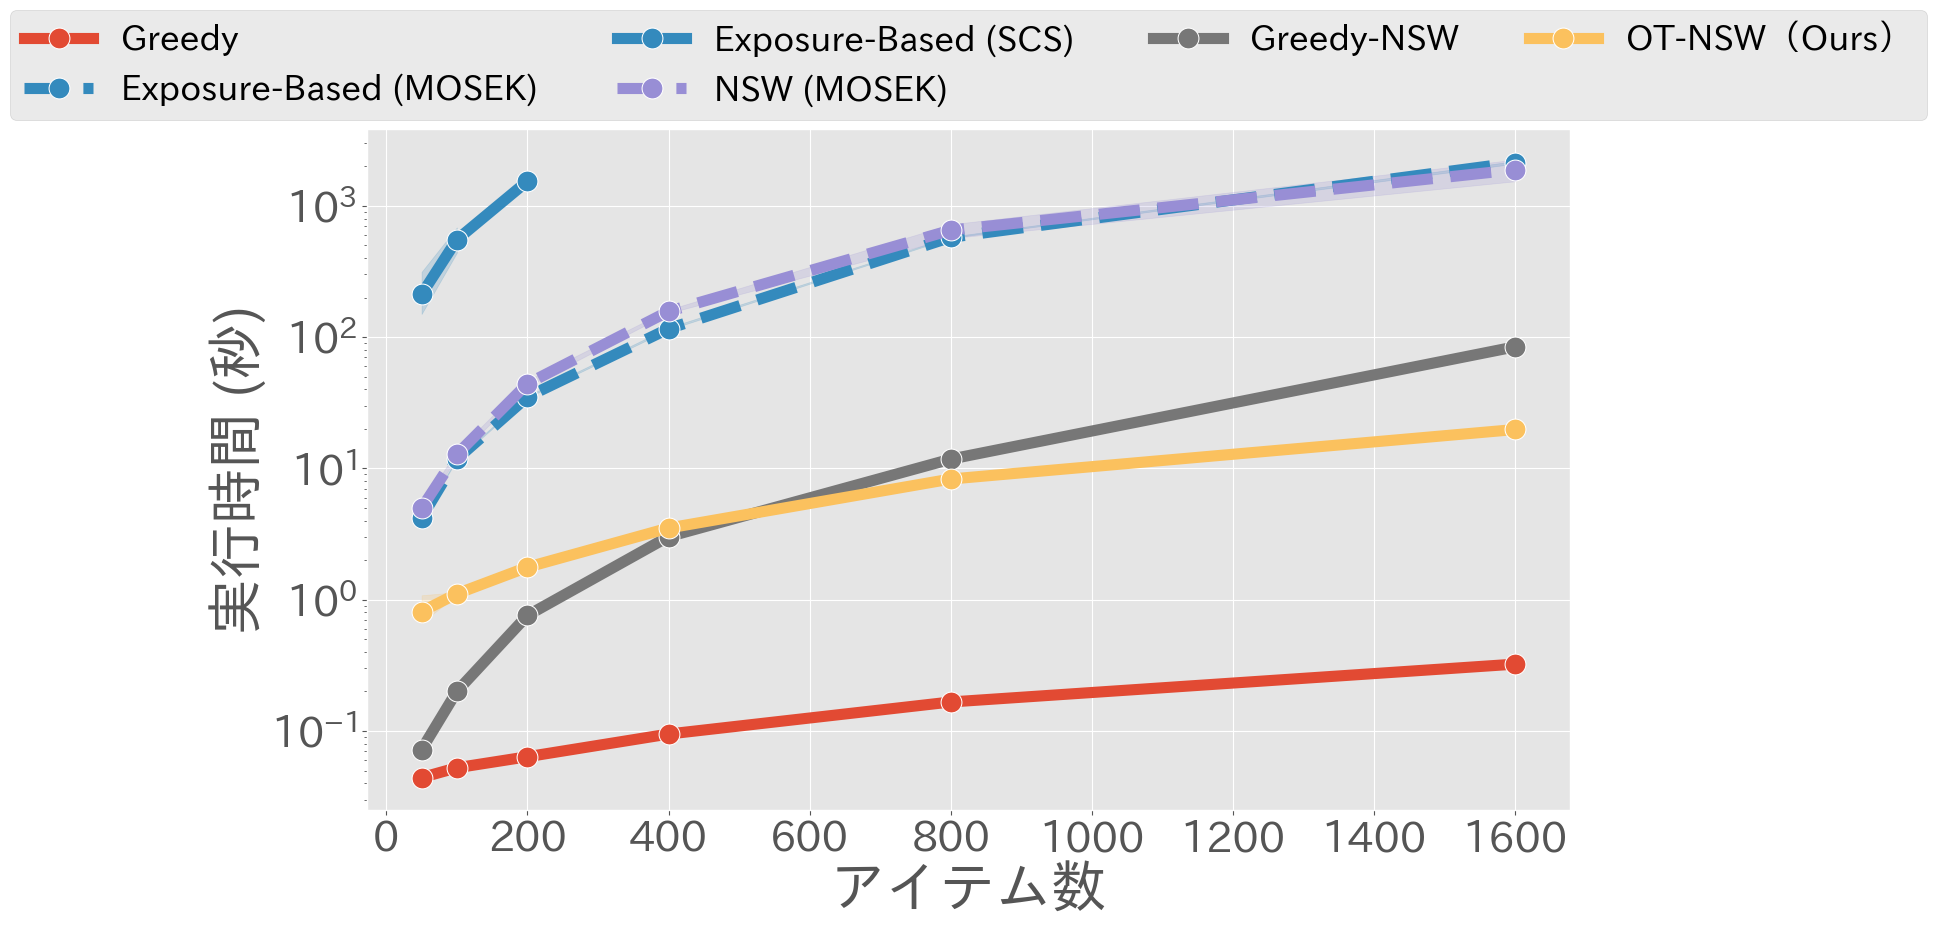

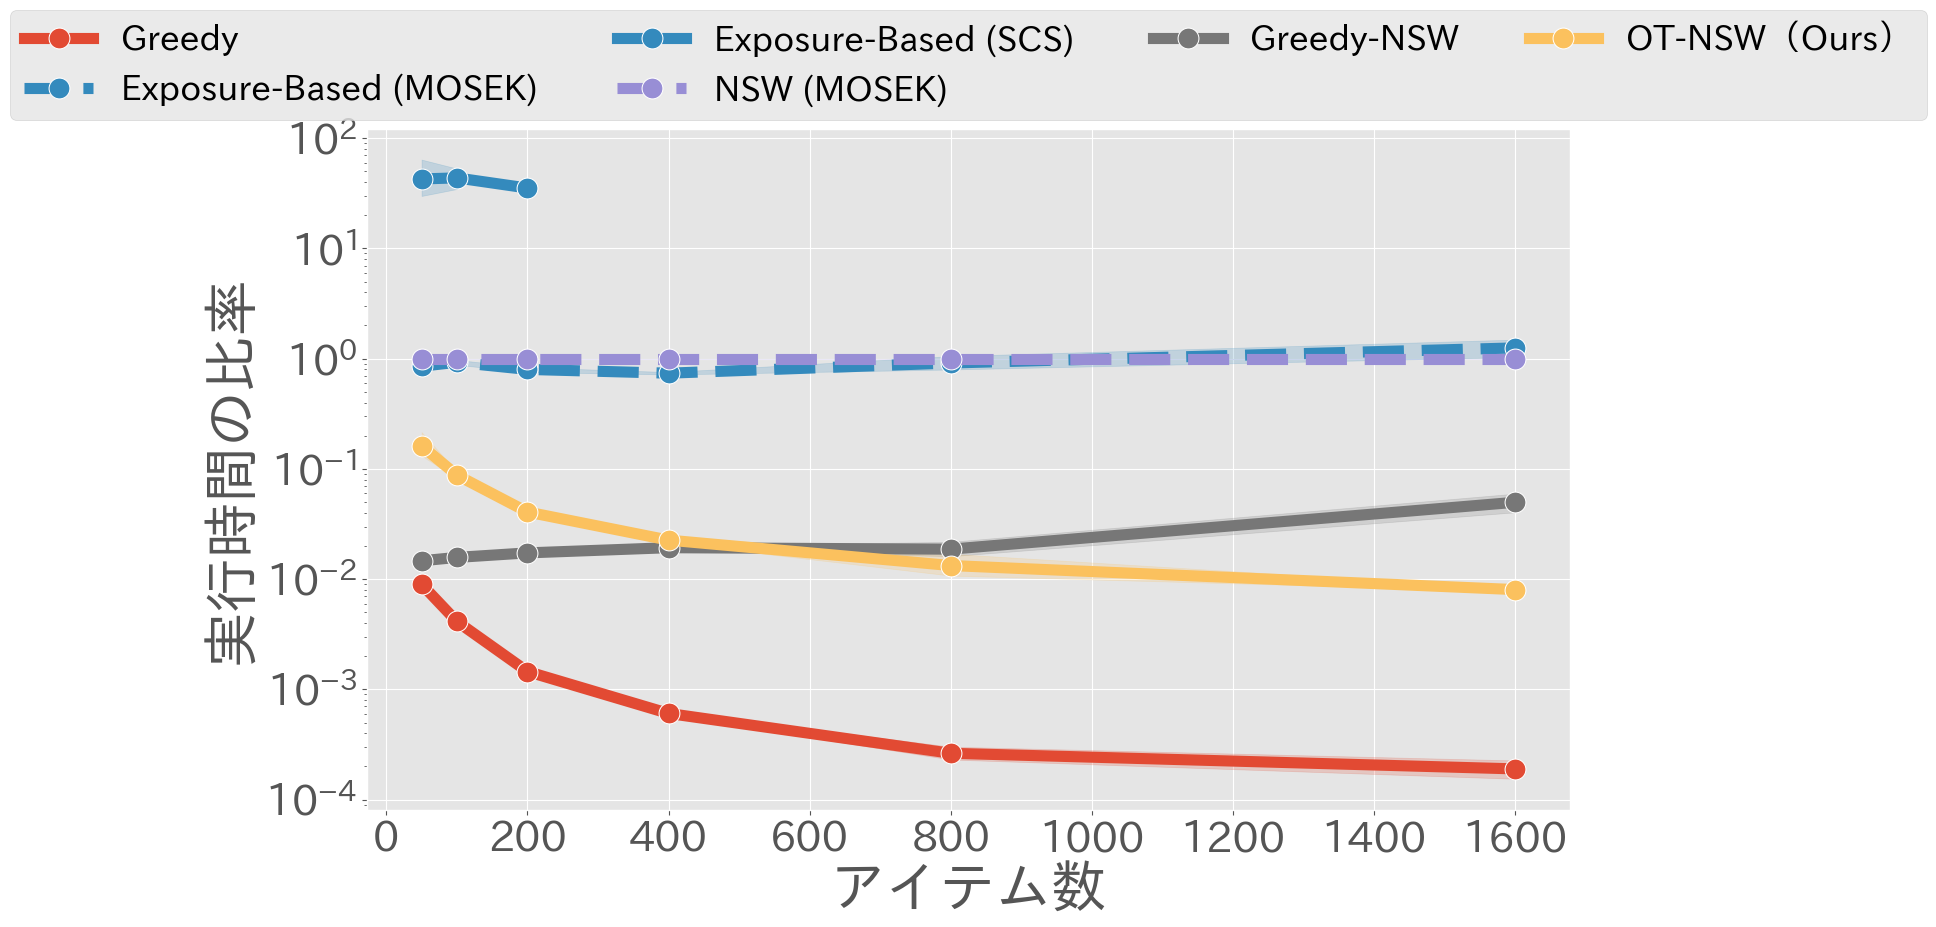

In [11]:
plot_exec_time(varying_item_size_result, x="generator_n_doc", xlabel="アイテム数")

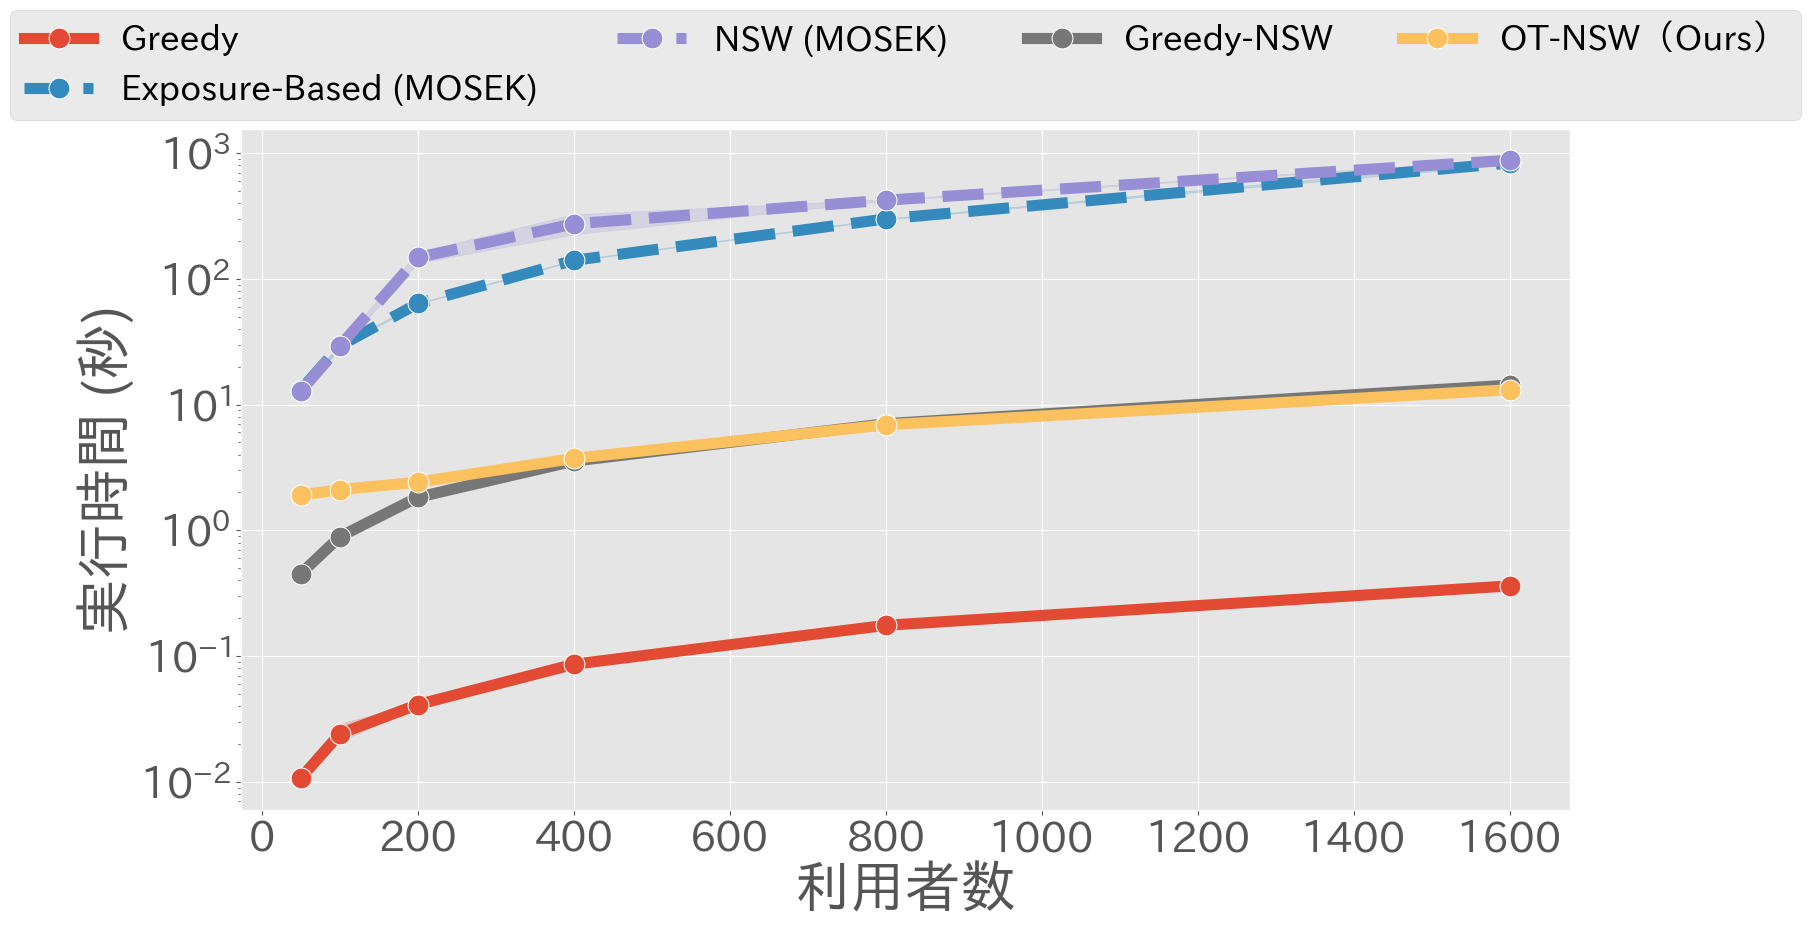

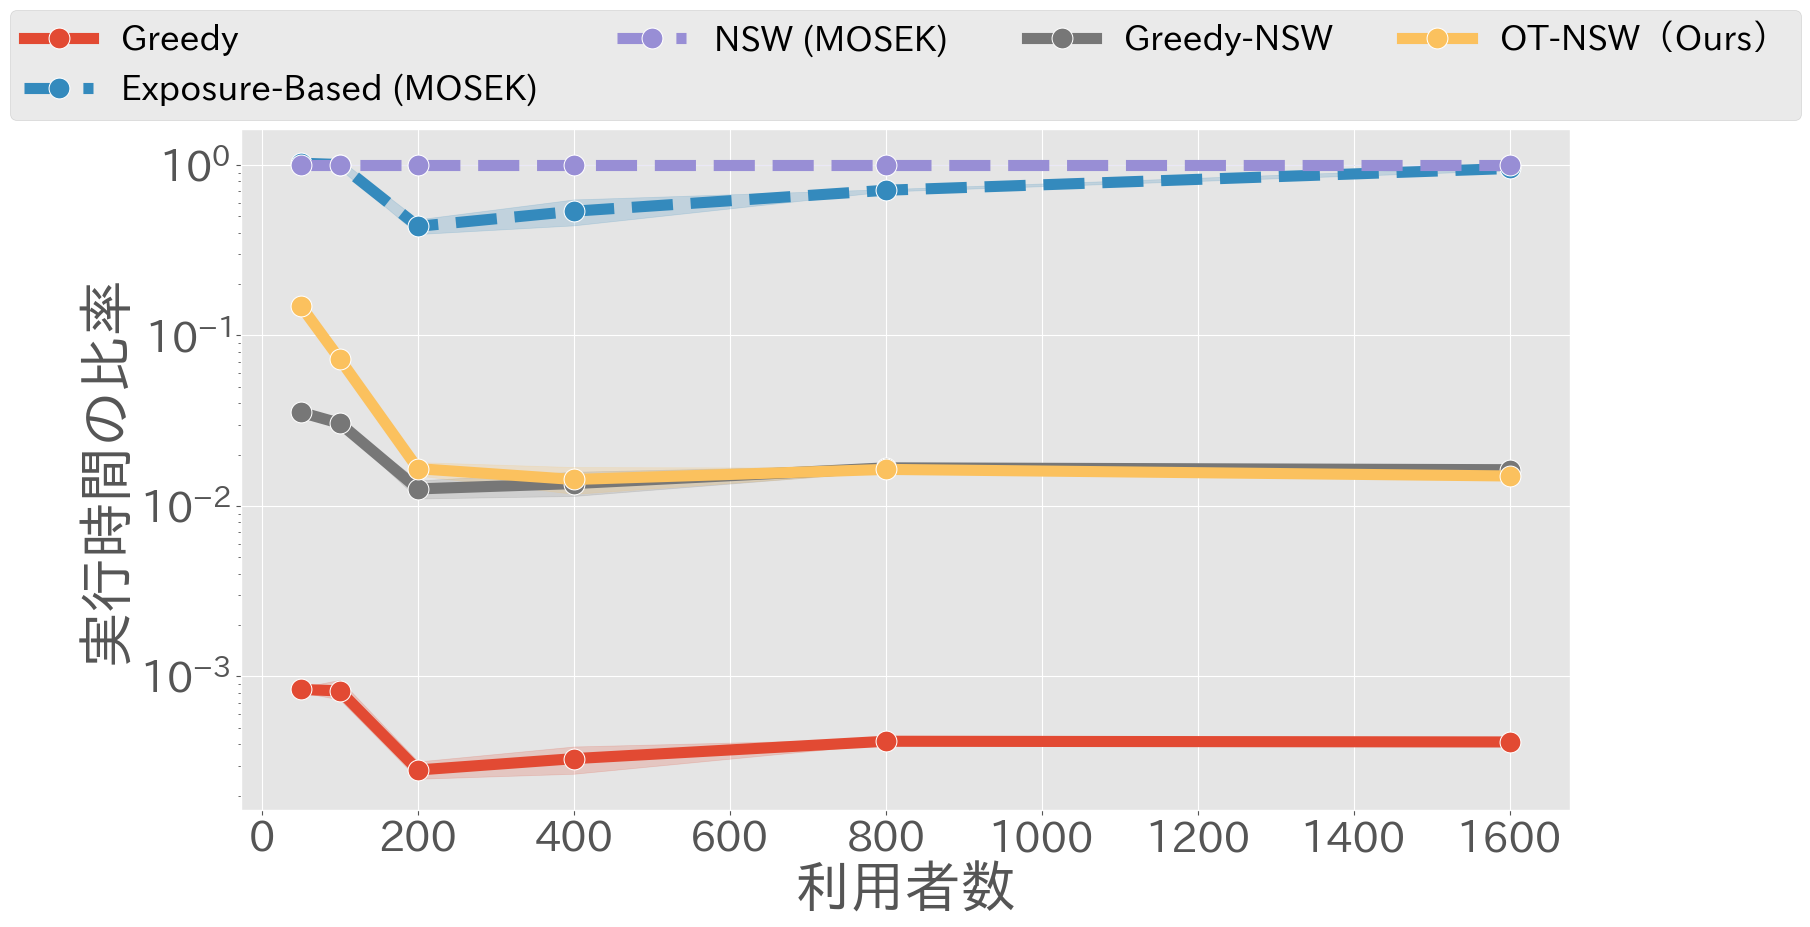

In [12]:
plot_exec_time(varying_user_size_result, x="generator_n_query", xlabel="利用者数")